# Evaluation Metrics

## Introduction
  This document aims to practice and show the knowledge acquired regarding metrics used for evaluating the performance of a ML model.
  We will run a classification model, extract its confusioin matrix and calculate the most common metrics ( sensitivity, specificity accuracy, precision and f-score ).
  We will use the same model we created for the classification of cats, dogs and chickens.

## Setup



In [46]:
import os

import tensorflow as tf

import random
import numpy as np
import keras

import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.models import Model


### Download images 

  The images were stored in a google drive, each category in a different file.
  Here we download each file and recreate the dataset.

In [47]:
! wget -nv "https://drive.google.com/uc?export=download&id=1LsjVG1a-UzTNytoMph8YFhXQL6iFCyRK" -O dataset.tar.gz
! tar -xf dataset.tar.gz && rm dataset.tar.gz

! wget -nv "https://drive.google.com/uc?export=download&id=1FQxpmo1oeFu0FpVmRLKs5JhyburBnzT7" -O dataset.tar.gz
! tar -xf dataset.tar.gz && rm dataset.tar.gz

! wget -nv "https://drive.google.com/uc?export=download&id=1JgLakcUHbcgOhmcwWhCHUCNKuRWt2EHj" -O dataset.tar.gz
! tar -xf dataset.tar.gz && rm dataset.tar.gz


2025-02-05 18:39:39 URL:https://drive.usercontent.google.com/download?id=1LsjVG1a-UzTNytoMph8YFhXQL6iFCyRK&export=download [13612509/13612509] -> "dataset.tar.gz" [1]
2025-02-05 18:39:46 URL:https://drive.usercontent.google.com/download?id=1FQxpmo1oeFu0FpVmRLKs5JhyburBnzT7&export=download [16587496/16587496] -> "dataset.tar.gz" [1]
2025-02-05 18:39:53 URL:https://drive.usercontent.google.com/download?id=1JgLakcUHbcgOhmcwWhCHUCNKuRWt2EHj&export=download [18510721/18510721] -> "dataset.tar.gz" [1]


#### Load Images in a array
Each directory inside dataset represents a category. The name of each directory being name of the category it represents.

In [48]:
root = 'dataset'
categories = [x[0] for x in os.walk(root) if x[0]][1:]
#categories = [x.split(os.path.sep)[1] for x in categories]
print(categories)

['dataset/Chicken', 'dataset/Dog', 'dataset/Cat']


In [49]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [50]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    p_imgs_errs = []
    for img_path in images:
      try:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})
      except Exception as e:
        p_imgs_errs.append(img_path)
    if p_imgs_errs: 
      print(f"{category}: {p_imgs_errs}")


### Preparing the data

Here we prepare the loaded data for the algorithm. We normalize all the data, then shuffle to randomize and avoid bias. In the end, we split it into three sets: training, testing, and validation.

In [51]:
# count the number of classes
num_classes = len(categories)
random.shuffle(data)

Separate the data into sets.

In [52]:
train_split, val_split = 0.7, 0.15

idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))

train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]

x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]

x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

Normalize the data and convert the labels.

In [53]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [54]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 1452 images from 3 categories
train / validation / test split: 1016, 218, 218
training data shape:  (1016, 224, 224, 3)
training labels shape:  (1016, 3)


A few samples from our dataset.

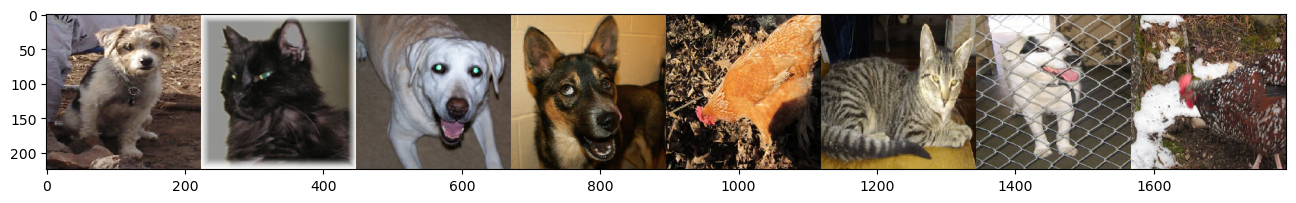

In [55]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)
plt.show()

## Training

### Baseline model

#### Build

In [56]:
# build the network
model = Sequential()

model.add(Input(x_train.shape[1:]))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,209,315 (4.61 MB)

 Trainable params: 1,209,315 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

#### Train

In [57]:
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.3752 - loss: 1.1301 - val_accuracy: 0.4725 - val_loss: 1.0732
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4034 - loss: 1.0502 - val_accuracy: 0.6651 - val_loss: 0.9356
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5617 - loss: 0.9018 - val_accuracy: 0.6284 - val_loss: 0.8013
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5605 - loss: 0.8413 - val_accuracy: 0.6835 - val_loss: 0.7590
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6026 - loss: 0.7787 - val_accuracy: 0.6651 - val_loss: 0.7495
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6033 - loss: 0.7729 - val_accuracy: 0.6284 - val_loss: 0.7569
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6509 - loss: 0.7268 - val_accuracy: 0.6697 - val_loss: 0.6927
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6749 - loss: 0.7178 - val_accuracy: 0.6697 - val_loss: 0.7170
Epoch 9/

#### Evaluate

Here we will calculate the metrics for each category.
First we define a helper function to calculate our confusion matrix.
Then we calculate true/false positives/negatives for each category.

We can calculate accuracy for the whole test set, but doing so for each category can help us discover if there is an issue with a category and correct it. Maybe the network works great for chickens, but not so much for dogs. We would then try to add more dog images to improve its metrics.

In [58]:
# category is the index of the category in the output array
def calc_confusion_matrix(category, x, y):
  TP = 0
  FP = 0
  FN = 0
  TN = 0
  for i, p in enumerate(model.predict(x)):
    _max = max(p)
    # POSITIVE
    if p[category] == _max:
      # TRUE
      if y[i][category] == 1:
        TP += 1
      #FALSE
      else:
        FP += 1
    # NEGATIVE
    else:
      # FALSE
      if y[i][category] == 1:
        FN += 1
      else:
        TN += 1
  return [[TP, FP],[FN, TN]]

cat_matrix = [(cat, calc_confusion_matrix(cat_idx, x_test, y_test)) for cat_idx, cat in enumerate(categories)]

print(cat_matrix)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
[('dataset/Chicken', [[65, 20], [4, 129]]), ('dataset/Dog', [[25, 22], [51, 120]]), ('dataset/Cat', [[48, 38], [25, 107]])]


In [66]:
def get_probability_metrics(confusion_matrix):
  TP, FP = confusion_matrix[0]
  FN, TN = confusion_matrix[1]
  sensitivity = TP/(TP+FN)
  specificity = TN/(FP+TN)
  accuracy = (TP+TN)/(TP+FP+FN+TN)
  precision = TP/(TP+FP)
  f_score = 2*(precision*sensitivity)/(precision+sensitivity)
  return sensitivity, specificity, accuracy, precision, f_score

for (cat, mtx) in cat_matrix:
  sensitivity, specificity, accuracy, precision, f_score = get_probability_metrics(mtx)
  print("statistics for category: ", cat, mtx)
  print("sensibilidade: ", sensitivity)
  print("especificidade: ", specificity)
  print("acurácia: ", accuracy )
  print("precisão: ", precision )
  print("f-score: ", f_score)
  print("---------------------")


statistics for category:  dataset/Chicken [[65, 20], [4, 129]]
sensibilidade:  0.9420289855072463
especificidade:  0.8657718120805369
acurácia:  0.8899082568807339
precisão:  0.7647058823529411
f-score:  0.8441558441558441
---------------------
statistics for category:  dataset/Dog [[25, 22], [51, 120]]
sensibilidade:  0.32894736842105265
especificidade:  0.8450704225352113
acurácia:  0.6651376146788991
precisão:  0.5319148936170213
f-score:  0.4065040650406504
---------------------
statistics for category:  dataset/Cat [[48, 38], [25, 107]]
sensibilidade:  0.6575342465753424
especificidade:  0.7379310344827587
acurácia:  0.7110091743119266
precisão:  0.5581395348837209
f-score:  0.6037735849056604
---------------------


Considering the results above, we can see that our network is pretty good ad identifying chickens, but not so good for dogs. It would be a good idea  to get more dog images in our dataset in order to improve our learning of dogs.